
# Pré-Processamento: Aprendizagem Automática

## Objetivo
Para um dataset com o histórico de vendas semanais de diversos produtos, será necessário desenvolver uma função que divide os dados de vendas em diferentes dataframes, um para cada produto, criando e treinando dois modelos para um desses dataframes, um para receitas e outro para o nº de unidades vendidas, armazenando o modelo resultado (função Y=mx +b) e prevendo as receitas e o nº de unidades vendidas num ficheiro .csv, para dps este ficheiro ser consumido pelo método de otimização, permitindo que o mesmo usufrua das previsões obtidas. 

Deverão existir dois modelos por produto, um para prever as unidades vendidas no dia seguinte e outro para prever o lucro de vendas do dia seguinte. O período de vendas utilizado será diário ou semanal (a determinar), sendo esta escolha fruto de análise. É importante salientar que o modelo de otimização terá como objetivo otimizar as quantidades a ter em stock durante X semanas, sendo X um valor configurável que representa a periodicidade média de reabastecimento de stock por produto utilizado pela loja, sendo este período representado no mesmo intervalo temporal dos modelos, isto é, em dias ou semanas (a determinar).

In [96]:
%%capture
%pip install pandas
%pip install xlrd
%pip install openpyxl
%pip install unidecode
%pip install scikit-learn
%pip install matplotlib
%pip install seaborn
%pip install statsmodels
%pip install xgboost

In [61]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from datetime import datetime, timedelta
from sklearn.model_selection import train_test_split
from numpy import sqrt
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from xgboost import XGBRegressor

import warnings
warnings.filterwarnings('ignore')


In [62]:


# Lemos o dataset
df = pd.read_csv('dataset/sales.csv')

# Verificamos o dataset carregado
print(df.head(5))


  product_id store_id        date  sales  revenue  stock  price promo_type_1  \
0      P0001    S0002  2017-01-02    0.0     0.00    8.0   6.25         PR14   
1      P0001    S0012  2017-01-02    1.0     5.30    0.0   6.25         PR14   
2      P0001    S0013  2017-01-02    2.0    10.59    0.0   6.25         PR14   
3      P0001    S0023  2017-01-02    0.0     0.00    6.0   6.25         PR14   
4      P0001    S0025  2017-01-02    0.0     0.00    1.0   6.25         PR14   

  promo_bin_1 promo_type_2 promo_bin_2  promo_discount_2 promo_discount_type_2  
0         NaN         PR03         NaN               NaN                   NaN  
1         NaN         PR03         NaN               NaN                   NaN  
2         NaN         PR03         NaN               NaN                   NaN  
3         NaN         PR03         NaN               NaN                   NaN  
4         NaN         PR03         NaN               NaN                   NaN  


In [63]:

# Verificamos o período do dataset
def revenue_duration(data):
    data.date = pd.to_datetime(data.date)
    number_of_days = data.date.max() - data.date.min()
    number_of_years = number_of_days.days / 365
    print(number_of_days.days, 'dias')
    print(number_of_years, 'anos')
    
revenue_duration(df)


1091 dias
2.989041095890411 anos


In [64]:

# Verificamos que cada produto tem vários registos por dia, dado que para cada produto existem mais registos do que o total de dias acima ilustrado, sendo estes
# referentes às diferentes lojas em que foram vendidos. Porém, para efeitos de análise, iremos agrupar as vendas diárias de cada produto em todas as lojas numa só linha.
print(df['product_id'].value_counts().sort_values(ascending=False).head(15))



P0125    140997
P0364    140569
P0261    139651
P0333    139632
P0664    139486
P0390    139332
P0131    139014
P0536    138856
P0499    138228
P0116    137142
P0569    137132
P0372    136738
P0103    135841
P0642    134062
P0129    133990
Name: product_id, dtype: int64


In [65]:


# Verificamos as percentagens de dados em falta
percent_missing = df.isnull().sum() * 100 / len(df)
percent_missing.sort_values(ascending=False).head()



promo_bin_2              99.696317
promo_discount_2         99.696317
promo_discount_type_2    99.696317
promo_bin_1              86.370028
sales                     6.120647
dtype: float64

In [66]:


# Verificamos a distribuição das colunas de valores de promoção que estão preenchidas
print(df[df['product_id'] == 'P0004']['promo_type_1'].value_counts().sort_values(ascending=False).head(15))



PR14    2092
Name: promo_type_1, dtype: int64


In [67]:


# Verificamos a distribuição das colunas de valores de promoção que estão preenchidas
print(df[df['product_id'] == 'P0004']['promo_type_2'].value_counts().sort_values(ascending=False).head(15))



PR03    2092
Name: promo_type_2, dtype: int64


In [68]:


# Removemos as colunas cujas percentagens de inutilização são evidentemente superiores ao aceitável
df = df.drop(columns=["promo_bin_2", "promo_discount_2", "promo_discount_type_2", "promo_bin_1"])

# Removemos as colunas cuja distribuição é quase 100% para um determinado valor, dado que não terão impacto no modelo
df = df.drop(columns=["promo_type_1","promo_type_2"])
print(df.head(5))



  product_id store_id       date  sales  revenue  stock  price
0      P0001    S0002 2017-01-02    0.0     0.00    8.0   6.25
1      P0001    S0012 2017-01-02    1.0     5.30    0.0   6.25
2      P0001    S0013 2017-01-02    2.0    10.59    0.0   6.25
3      P0001    S0023 2017-01-02    0.0     0.00    6.0   6.25
4      P0001    S0025 2017-01-02    0.0     0.00    1.0   6.25


In [69]:


# Verificamos novamente as percentagens de dados em falta
percent_missing = df.isnull().sum() * 100 / len(df)
percent_missing.sort_values(ascending=False).head()



sales         6.120647
revenue       6.120647
stock         6.120647
price         2.940045
product_id    0.000000
dtype: float64

In [70]:


# Agrupamos as vendas semanais por produto, por semana.
# Para manter o preço diário de cada produto, como este pode variar de loja para loja, inferimos a média do preço diário de cada produto entre todas as lojas, embora à partida não seja utilizado.
df['year'] = df.date.dt.isocalendar().year.astype("int64")
df['week'] = df.date.dt.isocalendar().week.astype("int64")
df2 = df.groupby(["product_id", "year","week"]).agg({'sales': ['sum'], 'revenue': ['sum'], 'stock': ['sum'], 'price': ['mean']}).reset_index()
df2.columns = df2.columns.droplevel(1)
df2['date'] = df2.apply(lambda row: datetime.strptime(f'{row.year} {row.week} 1', '%G %V %u'), axis=1)

print(df2.head(15))




   product_id  year  week  sales  revenue   stock    price       date
0       P0001  2017     1   24.0   127.17  1318.0  6.25000 2017-01-02
1       P0001  2017     2   21.0   112.97  1174.0  6.31713 2017-01-09
2       P0001  2017     3   15.0    82.65  1040.0  6.50000 2017-01-16
3       P0001  2017     4    8.0    44.08   961.0  6.50000 2017-01-23
4       P0001  2017     5   12.0    66.12   904.0  6.50000 2017-01-30
5       P0001  2017     6   18.0    99.18   804.0  6.50000 2017-02-06
6       P0001  2017     7    5.0    27.55   742.0  6.50000 2017-02-13
7       P0001  2017     8    2.0    11.02   704.0  6.50000 2017-02-20
8       P0001  2017     9    7.0    38.57   661.0  6.50000 2017-02-27
9       P0001  2017    10   11.0    60.60   607.0  6.50000 2017-03-06
10      P0001  2017    11    7.0    38.57   473.0  6.50000 2017-03-13
11      P0001  2017    12    6.0    33.06   408.0  6.50000 2017-03-20
12      P0001  2017    13    4.0    22.04   367.0  6.50000 2017-03-27
13      P0001  2017 

In [71]:

# Verificamos novamente a quantidade de registos por produto, sendo que este valor deverá diminuir drasticamente face à análise igual feita anteriormente
# Assim, a quantidade agora deverá ser igual para todos os produtos, tendo como valor o total de semanas do dataset.
print(df2['product_id'].value_counts().sort_values(ascending=False).head(15))



P0001    156
P0571    156
P0613    156
P0611    156
P0609    156
P0608    156
P0602    156
P0599    156
P0591    156
P0590    156
P0587    156
P0585    156
P0583    156
P0579    156
P0574    156
Name: product_id, dtype: int64


In [72]:

# Verificamos novamente a quantidade de registos por produto, mas por ordem ascendente
print(df2['product_id'].value_counts().sort_values(ascending=True).head(15))


P0146    2
P0194    3
P0627    3
P0589    3
P0403    3
P0019    3
P0257    4
P0605    4
P0507    6
P0285    6
P0111    6
P0618    6
P0032    7
P0064    7
P0384    7
Name: product_id, dtype: int64


In [73]:

# Exportamos o Dataset já agrupado caso seja pretendido analisar os dados ao pormenor. (opcional)
#df2.to_csv('dataset/revenue_grouped.csv')



In [74]:


# Verificamos novamente as percentagens de dados em falta, já com as vendas agrupadas
percent_missing = df2.isnull().sum() * 100 / len(df2)
percent_missing.sort_values(ascending=False).head()



price         2.034404
product_id    0.000000
year          0.000000
week          0.000000
sales         0.000000
dtype: float64

In [75]:


# Dividimos o dataframe por produto, dado que irá ser treinado um modelo de previsão para cada um.
dfByProdList = df2.groupby("product_id")

print(len(dfByProdList))

    

649


In [76]:

# Para efeitos de análise, iremos inicialmente começar por criar um modelo somente para alguns produtos de teste.
product_df_Test1 = dfByProdList.get_group('P0001')
product_df_Test2 = dfByProdList.get_group('P0748')
product_df_Test3 = dfByProdList.get_group('P0125')
print(product_df_Test1.head())



  product_id  year  week  sales  revenue   stock    price       date
0      P0001  2017     1   24.0   127.17  1318.0  6.25000 2017-01-02
1      P0001  2017     2   21.0   112.97  1174.0  6.31713 2017-01-09
2      P0001  2017     3   15.0    82.65  1040.0  6.50000 2017-01-16
3      P0001  2017     4    8.0    44.08   961.0  6.50000 2017-01-23
4      P0001  2017     5   12.0    66.12   904.0  6.50000 2017-01-30


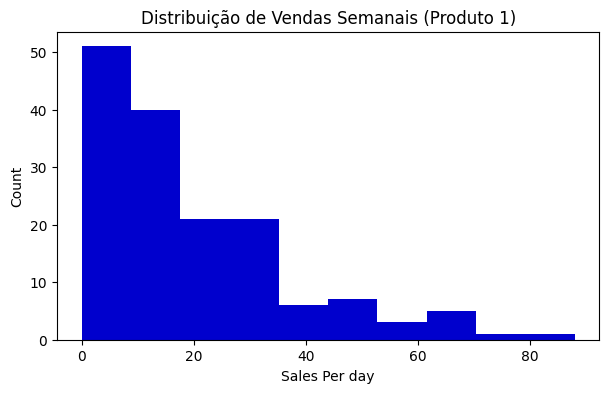

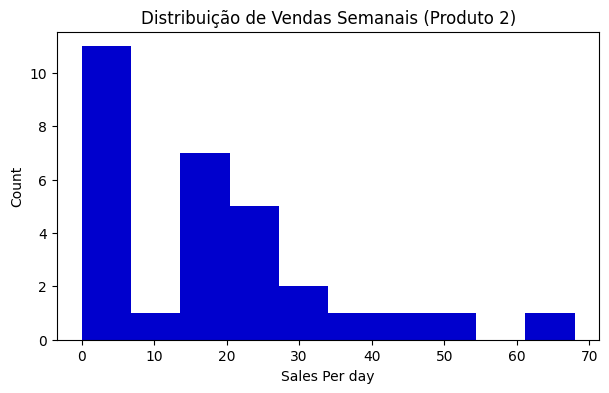

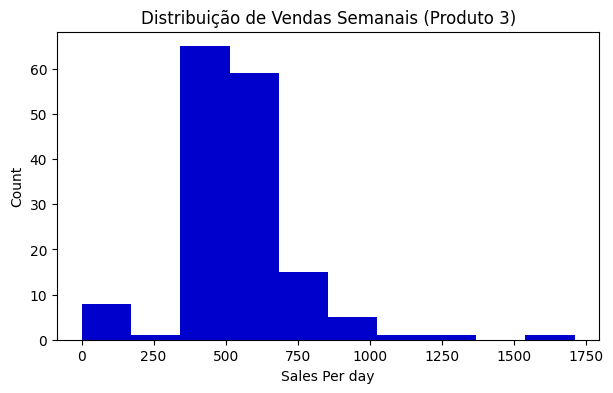

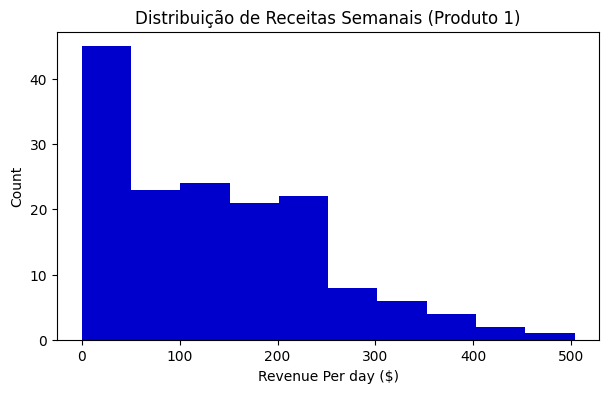

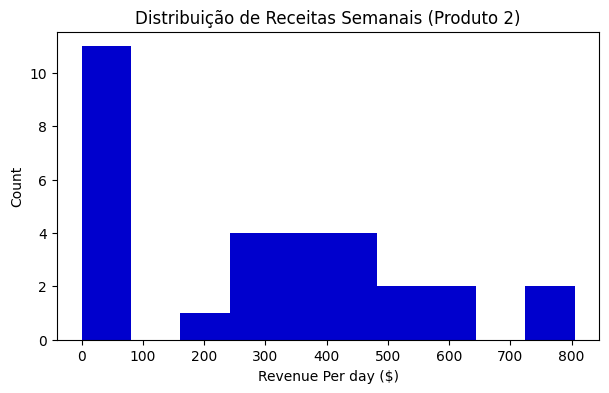

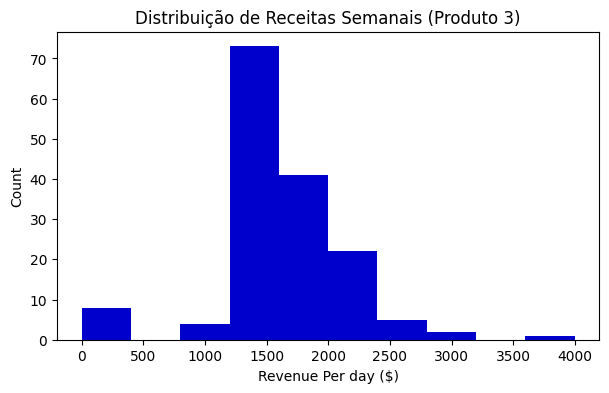

In [77]:


# Verificamos a distribuição de vendas semanais para os produtos de teste
def sales_per_day(product_sales_data, title):
    fig, ax = plt.subplots(figsize=(7,4))
    plt.hist(product_sales_data.sales, color='mediumblue')
    
    ax.set(xlabel = "Sales Per day", ylabel = "Count", title = title)
    
def revenue_per_day(product_sales_data, title):
    fig, ax = plt.subplots(figsize=(7,4))
    plt.hist(product_sales_data.revenue, color='mediumblue')
    
    ax.set(xlabel = "Revenue Per day ($)", ylabel = "Count", title = title )


sales_per_day(product_df_Test1, "Distribuição de Vendas Semanais (Produto 1)")
sales_per_day(product_df_Test2, "Distribuição de Vendas Semanais (Produto 2)")
sales_per_day(product_df_Test3, "Distribuição de Vendas Semanais (Produto 3)")
revenue_per_day(product_df_Test1, "Distribuição de Receitas Semanais (Produto 1)")
revenue_per_day(product_df_Test2, "Distribuição de Receitas Semanais (Produto 2)")
revenue_per_day(product_df_Test3, "Distribuição de Receitas Semanais (Produto 3)")




In [78]:


# Verificamos a média de vendas e receitas semanais
avg_monthly_sales1 = product_df_Test1.sales.mean()
avg_monthly_sales2 = product_df_Test2.sales.mean()
avg_monthly_sales3 = product_df_Test3.sales.mean()
avg_monthly_revenue1 = product_df_Test1.revenue.mean()
avg_monthly_revenue2 = product_df_Test2.revenue.mean()
avg_monthly_revenue3 = product_df_Test3.revenue.mean()
print(f"Média de vendas semanais (Produto 1): {avg_monthly_sales1}")
print(f"Média de vendas semanais (Produto 2): {avg_monthly_sales2}")
print(f"Média de vendas semanais (Produto 3): {avg_monthly_sales3}")
print(f"Média de receitas semanais (Produto 1): ${avg_monthly_revenue1}")
print(f"Média de receitas semanais (Produto 2): ${avg_monthly_revenue2}")
print(f"Média de receitas semanais (Produto 3): ${avg_monthly_revenue3}")



Média de vendas semanais (Produto 1): 19.03205128205128
Média de vendas semanais (Produto 2): 17.466666666666665
Média de vendas semanais (Produto 3): 537.4551282051282
Média de receitas semanais (Produto 1): $135.43871794871797
Média de receitas semanais (Produto 2): $276.73333333333335
Média de receitas semanais (Produto 3): $1606.9859615384614


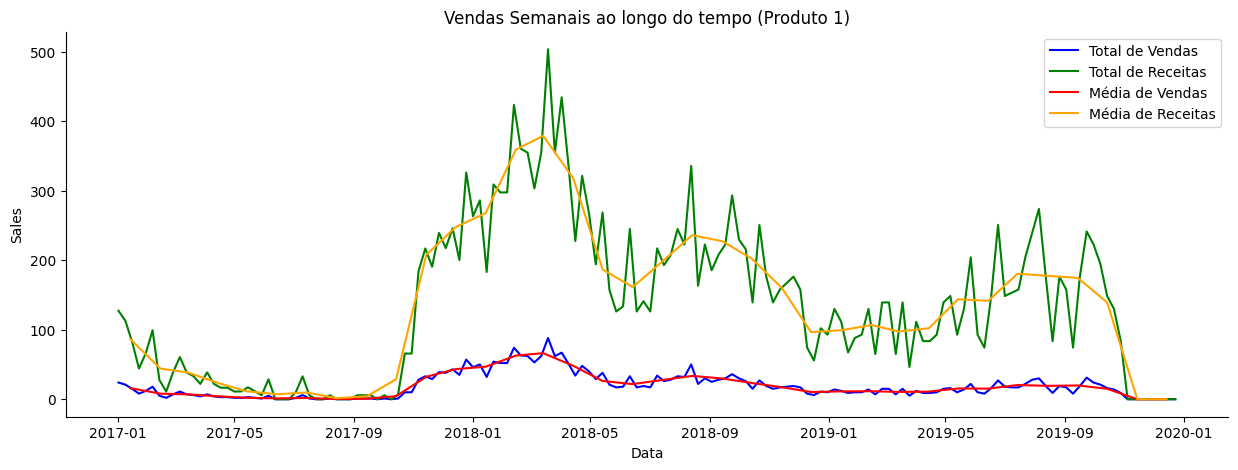

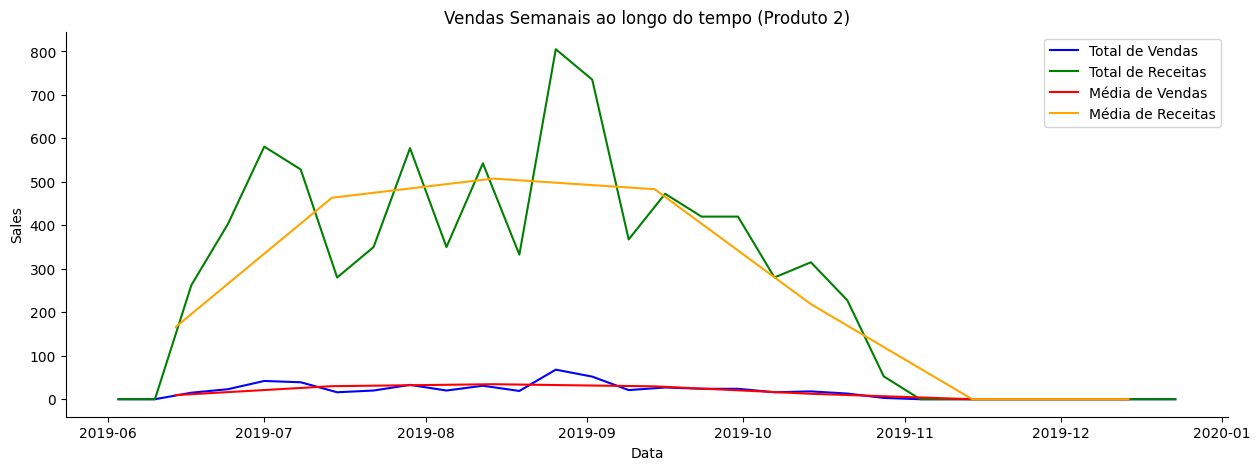

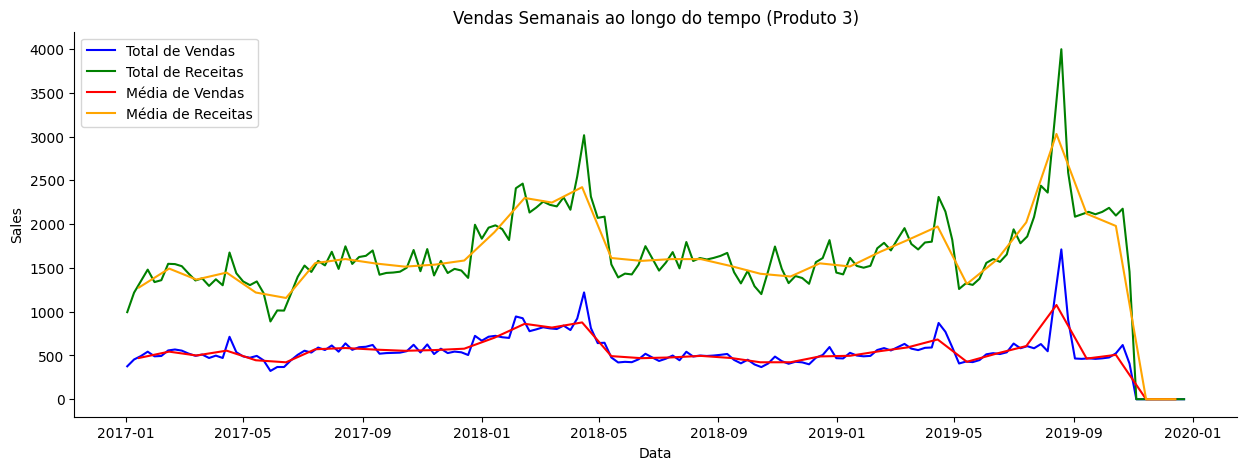

In [79]:

# Esta função permite verificar a Estacionariedade de um dataframe, permitindo aferir se os seus dados são estacionários ou não, sendo que 
# uma série temporal é considerada estacionária se a média, a variância e a autocorrelação forem constantes ao longo do tempo.
def time_plot(data, sales_col, rev_col, title, checkStationarity=True, checkForecasted=False):
    fig, ax = plt.subplots(figsize=(15,5))
    sns.lineplot(x = 'date', y = sales_col, data=data, ax=ax, color='blue', label='Total de Vendas')
    sns.lineplot(x = 'date', y = rev_col, data=data, ax=ax, color='green', label='Total de Receitas') 
    
    if checkStationarity:
        stationary_sales = data.copy()
        stationary_sales.date = stationary_sales.date.dt.to_period('M')
        stationary_sales = stationary_sales.groupby(stationary_sales.date)[sales_col].mean().reset_index()
        stationary_sales.date = pd.to_datetime(stationary_sales.date.astype(str), format='%Y-%m')
        sns.lineplot(x = (stationary_sales.date  + timedelta(3*52/12)), y = sales_col, data=stationary_sales, ax=ax, color='red', label='Média de Vendas')

        stationary_revenue = data.copy()
        stationary_revenue.date = stationary_revenue.date.dt.to_period('M')
        stationary_revenue = stationary_revenue.groupby(stationary_revenue.date)[rev_col].mean().reset_index()
        stationary_revenue.date = pd.to_datetime(stationary_revenue.date.astype(str), format='%Y-%m')
        sns.lineplot(x = (stationary_revenue.date  + timedelta(3*52/12)), y = rev_col, data=stationary_revenue, ax=ax, color='orange', label='Média de Receitas')

    if checkForecasted:
        sns.lineplot(x = 'date', y = 'forecasted_sales', data=data, ax=ax, color='yellow', label='Total de Vendas Previstas')
        sns.lineplot(x = 'date', y = 'forecasted_revenue', data=data, ax=ax, color='orange', label='Total de Receitas Previstas') 

    ax.set(xlabel = "Data", ylabel = "Sales", title = title)
    
    sns.despine()
    
# Verificamos o histórico de vendas semanais dos produtos ao longo do tempo, juntamente com uma análise da Estacionariedade dos dados
time_plot(product_df_Test1, 'sales', 'revenue', 'Vendas Semanais ao longo do tempo (Produto 1)')
time_plot(product_df_Test2, 'sales', 'revenue', 'Vendas Semanais ao longo do tempo (Produto 2)')
time_plot(product_df_Test3, 'sales', 'revenue', 'Vendas Semanais ao longo do tempo (Produto 3)')



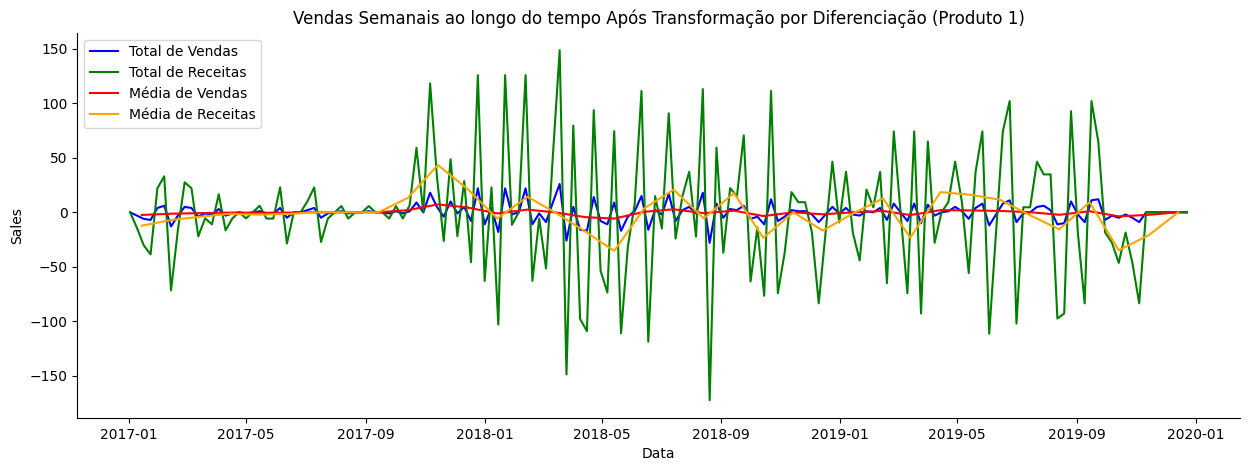

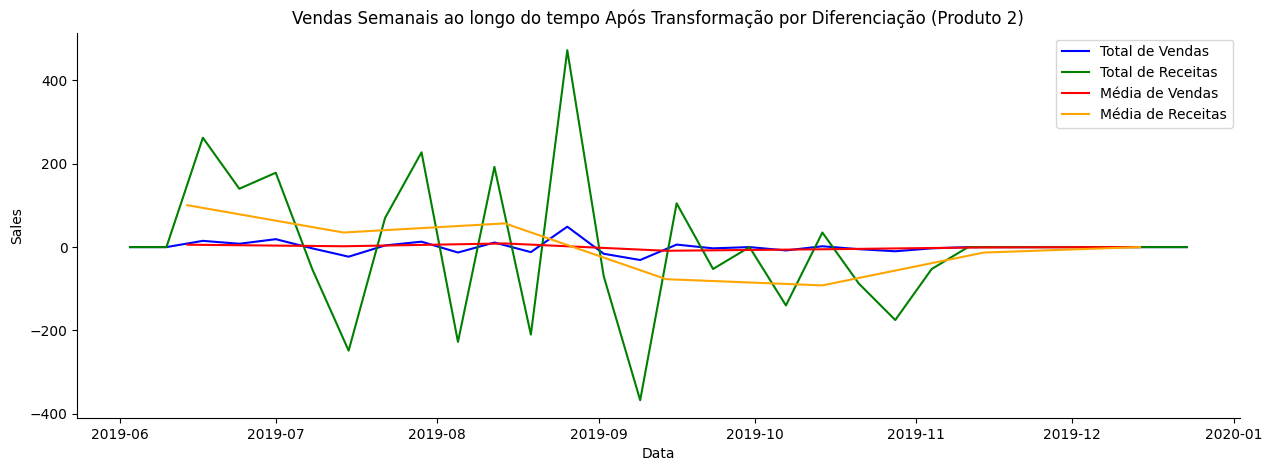

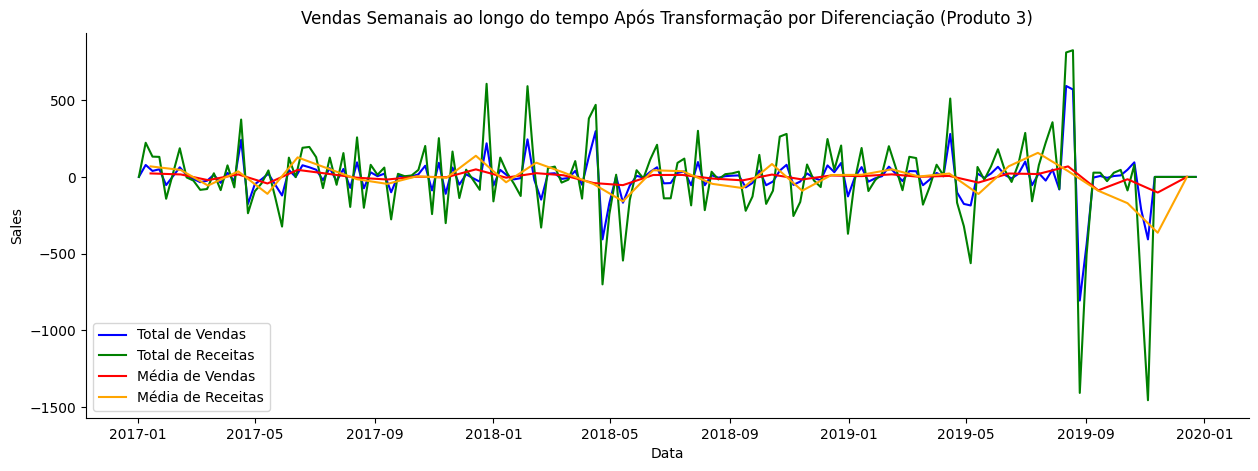

In [80]:


# Função para aplicar diferenciação a um dataframe, sendo esta uma técnica comumente utilizada para lidar com dados de séries temporais que não são estacionários
def get_diff(data):
    # Copiamos o dataframe original para evitar alterações ao mesmo
    data1 = data.copy()

    data1['sales_diff'] = data1.sales.diff()
    data1['revenue_diff'] = data1.revenue.diff()
    data1['sales_diff'] = data1['sales_diff'].fillna(0)
    data1['revenue_diff'] = data1['revenue_diff'].fillna(0)

    return data1

product_df_Test1_afterDiff = get_diff(product_df_Test1)
product_df_Test2_afterDiff = get_diff(product_df_Test2)
product_df_Test3_afterDiff = get_diff(product_df_Test3)

# Verificamos a diferença após aplicar a transformação por diferenciação
time_plot(product_df_Test1_afterDiff, 'sales_diff', 'revenue_diff', 'Vendas Semanais ao longo do tempo Após Transformação por Diferenciação (Produto 1)')
time_plot(product_df_Test2_afterDiff, 'sales_diff', 'revenue_diff', 'Vendas Semanais ao longo do tempo Após Transformação por Diferenciação (Produto 2)')
time_plot(product_df_Test3_afterDiff, 'sales_diff', 'revenue_diff', 'Vendas Semanais ao longo do tempo Após Transformação por Diferenciação (Produto 3)')




In [81]:


# Função para Deteção de outliers recorrendo a Tukey IQR
def find_outliers_tukey(x):
    q1 = np.percentile(x, 25)
    q3 = np.percentile(x, 75)
    iqr = q3-q1 
    floor = q1 - 1.5*iqr
    ceiling = q3 + 1.5*iqr
    outlier_indices = list(x.index[(x < floor)|(x > ceiling)])
    outlier_values = list(x[outlier_indices])
    return outlier_indices, outlier_values



In [82]:


# Verificamos se existem outliers a ter em consideração
tukey_values_sales1 = find_outliers_tukey(product_df_Test1['sales'])
tukey_values_sales2 = find_outliers_tukey(product_df_Test2['sales'])
tukey_values_sales3 = find_outliers_tukey(product_df_Test3['sales'])
tukey_values_revenue1 = find_outliers_tukey(product_df_Test1['revenue'])
tukey_values_revenue2 = find_outliers_tukey(product_df_Test2['revenue'])
tukey_values_revenue3 = find_outliers_tukey(product_df_Test3['revenue'])
print(f"Outliers das Vendas (Produto 1):\n {np.sort(tukey_values_sales1)}\n")
print(f"Outliers das Vendas (Produto 2):\n {np.sort(tukey_values_sales2)}\n")
print(f"Outliers das Vendas (Produto 3):\n {np.sort(tukey_values_sales3)}\n")
print(f"Outliers das Receitas (Produto 1):\n {np.sort(tukey_values_revenue1)}\n")
print(f"Outliers das Receitas (Produto 2):\n {np.sort(tukey_values_revenue2)}\n")
print(f"Outliers das Receitas (Produto 3):\n {np.sort(tukey_values_revenue3)}\n")



Outliers das Vendas (Produto 1):
 [[58. 59. 60. 62. 63. 64. 65.]
 [62. 62. 62. 63. 67. 74. 88.]]

Outliers das Vendas (Produto 2):
 [[7.0322e+04]
 [6.8000e+01]]

Outliers das Vendas (Produto 3):
 [[10624. 10625. 10627. 10628. 10629. 10630. 10631. 10633. 10634. 10635.
  10686. 10703. 10704. 10705. 10715. 10716. 10717. 10718. 10719. 10720.
  10721. 10722.]
 [    0.     0.     0.     0.     0.     0.     0.     0.   798.   802.
    809.   813.   822.   841.   871.   905.   922.   925.   945.  1141.
   1220.  1711.]]

Outliers das Receitas (Produto 1):
 [[ 63.  ]
 [503.36]]

Outliers das Receitas (Produto 2):
 []

Outliers das Receitas (Produto 3):
 [[10625.   10633.   10634.   10703.   10704.   10705.   10715.   10716.
  10717.   10718.   10719.   10720.   10721.   10722.  ]
 [    0.       0.       0.       0.       0.       0.       0.       0.
   2462.74  2545.41  2589.73  3015.44  3171.78  3997.77]]



In [83]:


# Verificamos se existem valores em falta para estes produtos
percent_missing1 = product_df_Test1.isnull().sum()
print(percent_missing1.sort_values(ascending=False).head())
percent_missing2 = product_df_Test2.isnull().sum()
print(percent_missing2.sort_values(ascending=False).head())
percent_missing3 = product_df_Test3.isnull().sum()
print(percent_missing3.sort_values(ascending=False).head())


product_id    0
year          0
week          0
sales         0
revenue       0
dtype: int64
product_id    0
year          0
week          0
sales         0
revenue       0
dtype: int64
product_id    0
year          0
week          0
sales         0
revenue       0
dtype: int64


In [84]:

# Função de preparação pré-previsão, sendo que esta foi separada para poder ser melhorada após análise do desempenho dos modelos obtidos
def prepareBeforePredict(dataframe):
    # Copiamos o dataframe original para evitar alterações ao mesmo
    dataframe1 = dataframe.copy()

    # Criamos uma nova coluna com o nº de vendas e receitas da semana imediatamente anterior
    dataframe1['prev_sales'] = dataframe1['sales'].shift(1)
    dataframe1['prev_revenue'] = dataframe1['revenue'].shift(1)

    # Preenchemos a primeira linha com o valor 0, dado que não existe registo anterior
    dataframe1['prev_sales'] = dataframe1['prev_sales'].fillna(0)
    dataframe1['prev_revenue'] = dataframe1['prev_revenue'].fillna(0)
    dataframe1 = dataframe1.astype({'sales':'int', 'prev_sales':'int', 'revenue':'int', 'prev_revenue':'int'})

    return dataframe1

# Verificamos o resultado da preparação
print(prepareBeforePredict(product_df_Test1).head())



  product_id  year  week  sales  revenue   stock    price       date  \
0      P0001  2017     1     24      127  1318.0  6.25000 2017-01-02   
1      P0001  2017     2     21      112  1174.0  6.31713 2017-01-09   
2      P0001  2017     3     15       82  1040.0  6.50000 2017-01-16   
3      P0001  2017     4      8       44   961.0  6.50000 2017-01-23   
4      P0001  2017     5     12       66   904.0  6.50000 2017-01-30   

   prev_sales  prev_revenue  
0           0             0  
1          24           127  
2          21           112  
3          15            82  
4           8            44  


In [85]:


# Função de previsão, devolvendo as métricas de avaliação de desempenho dos modelos obtidos
def find_model_perf(X_train, y_train, X_test, y_test, model):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    # Calculamos o MSE
    mse = mean_squared_error(y_test, y_pred)

    # Calculamos o RMSE
    rmse = sqrt(mse)

    # Calculamos o MAE
    mae = mean_absolute_error(y_test, y_pred)

    # Calculamos o R^2 score
    r2 = r2_score(y_test, y_pred)

    return y_pred, rmse, mae, r2
    

# Função total de previsão, recorrendo às funções de preparação e previsão
def predict(dataframe, model, salesColsToDrop, revenueColsToDrop):
    # Removemos as colunas que não deverão ser utilizadas pelo modelo, sendo que estas poderão variar caso tenham sido aplicadas técnicas de otimização ao dataframe
    X_sales = dataframe.drop(columns = salesColsToDrop, axis = 1)
    y_sales = dataframe.sales
    X_revenue = dataframe.drop(columns = revenueColsToDrop, axis = 1)
    y_revenue = dataframe.revenue

    X_train_sales, X_test_sales, y_train_sales, y_test_sales = train_test_split(X_sales, y_sales, train_size=0.7, random_state=1)
    X_train_revenue, X_test_revenue, y_train_revenue, y_test_revenue = train_test_split(X_revenue, y_revenue, train_size=0.7, random_state=1)

    y_pred_sales, rmse_sales, mae_sales, r2_sales = find_model_perf(X_train_sales, y_train_sales, X_test_sales, y_test_sales, model)
    y_pred_revenue, rmse_revenue, mae_revenue, r2_revenue = find_model_perf(X_train_revenue, y_train_revenue, X_test_revenue, y_test_revenue, model)

    # Armazenamos os índices dos conjuntos de teste
    test_sales_index = X_test_sales.index
    test_revenue_index = X_test_revenue.index

    # Adicionamos os indíces aos valores previstos
    y_pred_sales_df = pd.DataFrame(y_pred_sales, index = test_sales_index, columns=['forecasted_sales'])
    y_pred_revenue_df = pd.DataFrame(y_pred_revenue, index = test_revenue_index, columns=['forecasted_revenue'])
    
    # Juntamos o dataframe original com o dataframe de valores previstos
    dataframe_with_forecast= pd.merge(dataframe, y_pred_sales_df, left_index=True, right_index=True, how='outer')
    dataframe_with_forecast = pd.merge(dataframe_with_forecast, y_pred_revenue_df, left_index=True, right_index=True, how='outer')

    return rmse_sales, rmse_revenue, mae_sales, mae_revenue, r2_sales, r2_revenue, dataframe_with_forecast



In [86]:
model = XGBRegressor(objective='reg:squarederror')
salesColsToDrop = ['revenue', 'date', 'product_id','sales','stock','price','prev_revenue']
revenueColsToDrop = ['revenue', 'date', 'product_id','sales','stock','price','prev_sales']

# Verificamos a variação do desempenho dos modelos de previsão em alguns produtos diferentes
product_df_Test1_prep = prepareBeforePredict(product_df_Test1)
product_df_Test2_prep = prepareBeforePredict(product_df_Test2)
product_df_Test3_prep = prepareBeforePredict(product_df_Test3)
rmse_sales1, rmse_revenue1, mae_sales1, mae_revenue1, r2_sales1, r2_revenue1, dataframe_with_forecast1 = predict(product_df_Test1_prep, model, salesColsToDrop, revenueColsToDrop)
rmse_sales2, rmse_revenue2, mae_sales2, mae_revenue2, r2_sales2, r2_revenue2, dataframe_with_forecast2 = predict(product_df_Test2_prep, model, salesColsToDrop, revenueColsToDrop)
rmse_sales3, rmse_revenue3, mae_sales3, mae_revenue3, r2_sales3, r2_revenue3, dataframe_with_forecast3 = predict(product_df_Test3_prep, model, salesColsToDrop, revenueColsToDrop)

print(f"RMSE das Vendas (Produto 1): {rmse_sales1}")
print(f"RMSE das Vendas (Produto 2): {rmse_sales2}")
print(f"RMSE das Vendas (Produto 3): {rmse_sales3}")
print(f"Média RMSE das Vendas: {(rmse_sales1 + rmse_sales2 + rmse_sales3)/3}")
print(f"\nRMSE das Receitas (Produto 1): {rmse_revenue1}")
print(f"RMSE das Receitas (Produto 2): {rmse_revenue2}")
print(f"RMSE das Receitas (Produto 3): {rmse_revenue3}")
print(f"Média RMSE das Receitas: {(rmse_revenue1 + rmse_revenue2 + rmse_revenue3)/3}")
print(f"\nMAE das Vendas (Produto 1): {mae_sales1}")
print(f"MAE das Vendas (Produto 2): {mae_sales2}")
print(f"MAE das Vendas (Produto 3): {mae_sales3}")
print(f"Média MAE das Vendas: {(mae_sales1 + mae_sales2 + mae_sales3)/3}")
print(f"\nMAE das Receitas (Produto 1): {mae_revenue1}")
print(f"MAE das Receitas (Produto 2): {mae_revenue2}")
print(f"MAE das Receitas (Produto 3): {mae_revenue3}")
print(f"Média MAE das Receitas: {(mae_revenue1 + mae_revenue2 + mae_revenue3)/3}")
print(f"\nR2 Score das Vendas (Produto 1): {r2_sales1}")
print(f"R2 Score das Vendas (Produto 2): {r2_sales2}")
print(f"R2 Score das Vendas (Produto 3): {r2_sales3}")
print(f"Média R2 Score das Vendas: {(r2_sales1 + r2_sales2 + r2_sales3)/3}")
print(f"\nR2 Score das Receitas (Produto 1): {r2_revenue1}")
print(f"R2 Score das Receitas (Produto 2): {r2_revenue2}")
print(f"R2 Score das Receitas (Produto 3): {r2_revenue3}")
print(f"Média R2 Score das Receitas: {(r2_revenue1 + r2_revenue2 + r2_revenue3)/3}")



[19:12:14] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-08de971ced8a8cdc6-1/xgboost/xgboost-ci-windows/src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[19:12:14] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-08de971ced8a8cdc6-1/xgboost/xgboost-ci-windows/src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[19:12:14] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-08de971ced8a8cdc6-1/xgboost/xgboost-ci-windows/src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[19:12:14] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-08de971ced8a8cdc6-1/xgboost/xgboost-ci-windows/src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[19:12:14] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscal

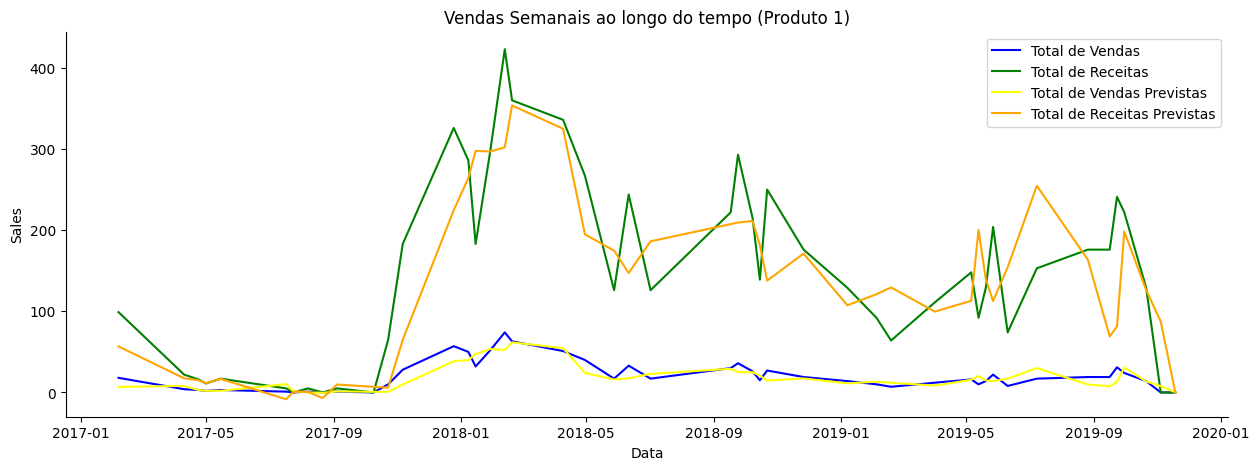

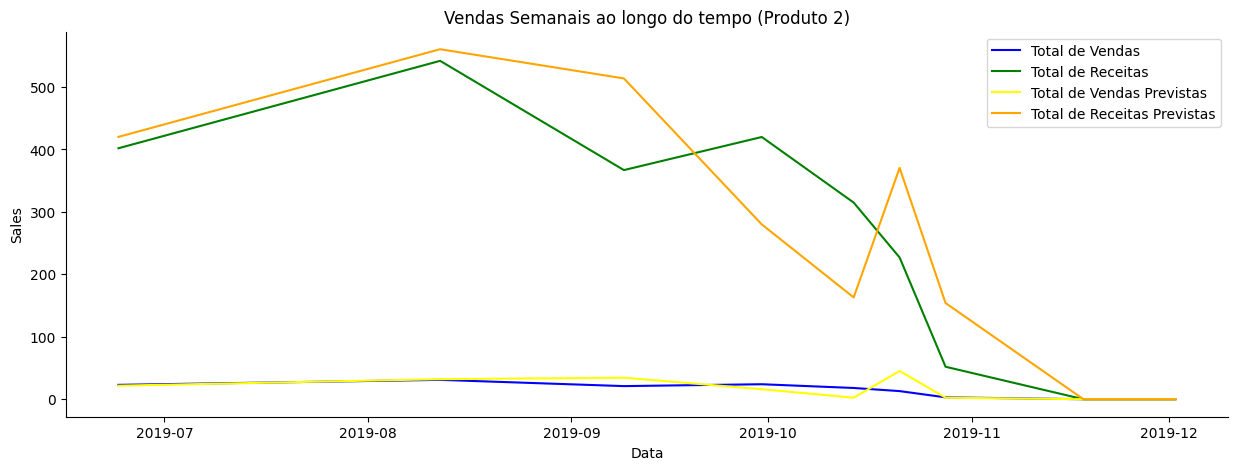

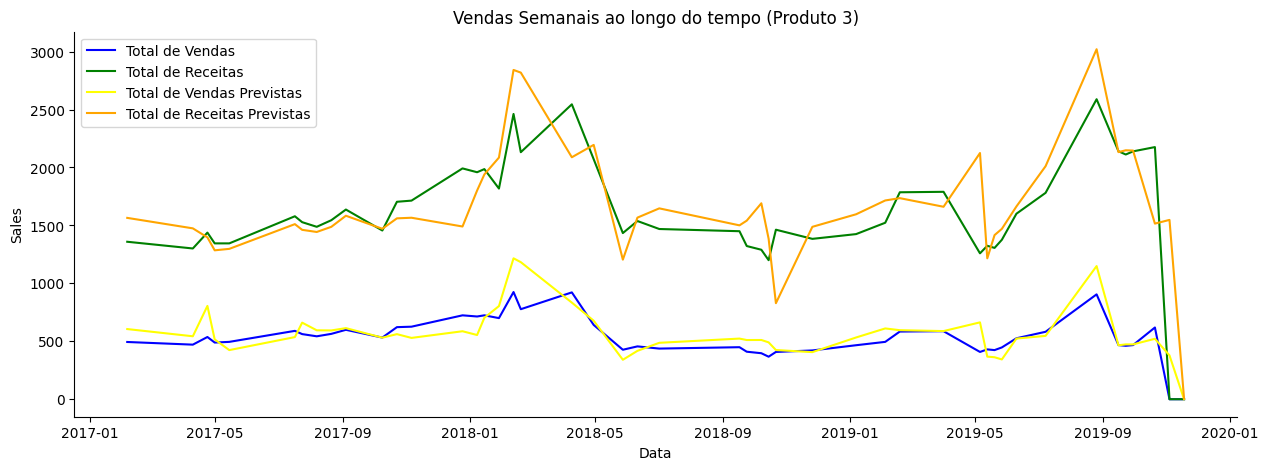

In [87]:


# Embora os resultados das previsões já sejam apresentados acima, aqui comparamos visualmente os valores previstos com os valores reais, permitindo
# aferir de uma forma mais percetível a discrepância entre os mesmos.
# É importante salientar que a linearidade não será, naturalmente, bem representada nestes gráficos, devido ao facto de o split de dados em conjuntos de teste e treino ter sido de forma aleatória,
# não contínua, isto é, são apenas apresentados os dados referentes à amostra de testes, para efeitos de comparação com as previsões. 
# A decisão de realizar o split desta forma, surge para evitar que o modelo se torne demasiado otimista para um determinado período contínuo, procurando mitigar a possibilidade de overfitting
time_plot(dataframe_with_forecast1.dropna(), 'sales', 'revenue', 'Vendas Semanais ao longo do tempo (Produto 1)', False, True)
time_plot(dataframe_with_forecast2.dropna(), 'sales', 'revenue', 'Vendas Semanais ao longo do tempo (Produto 2)', False, True)
time_plot(dataframe_with_forecast3.dropna(), 'sales', 'revenue', 'Vendas Semanais ao longo do tempo (Produto 3)', False, True)



In [88]:

# Função de preparação pré-previsão com aplicação de técnicas de otimização, nomeadamente a técnica de transformação por diferenciação
def prepareBeforePredictOptimized(dataframe):
    # Copiamos o dataframe original para evitar alterações ao mesmo
    dataframe1 = dataframe.copy()

    # Colocamos os valores numéricos como inteiros
    dataframe1 = dataframe1.astype({'sales':'int', 'revenue':'int'})

    # Criamos uma nova coluna com o nº de vendas e receitas da semana imediatamente anterior
    dataframe1['prev_sales'] = dataframe1['sales'].shift(1)
    dataframe1['prev_revenue'] = dataframe1['revenue'].shift(1)

    # Aplicamos a técnica de transformação por diferenciação
    dataframe1['diff_sales'] = dataframe1['sales'].diff()
    dataframe1['diff_revenue'] = dataframe1['revenue'].diff()

    # Preenchemos a primeira linha com o valor 0, dado que não existe registo anterior
    dataframe1['prev_sales'] = dataframe1['prev_sales'].fillna(0)
    dataframe1['prev_revenue'] = dataframe1['prev_revenue'].fillna(0)
    dataframe1['diff_sales'] = dataframe1['diff_sales'].fillna(0)
    dataframe1['diff_revenue'] = dataframe1['diff_revenue'].fillna(0)

    return dataframe1


# Verificamos o resultado da preparação otimizada
print(prepareBeforePredictOptimized(product_df_Test1).head())

  product_id  year  week  sales  revenue   stock    price       date  \
0      P0001  2017     1     24      127  1318.0  6.25000 2017-01-02   
1      P0001  2017     2     21      112  1174.0  6.31713 2017-01-09   
2      P0001  2017     3     15       82  1040.0  6.50000 2017-01-16   
3      P0001  2017     4      8       44   961.0  6.50000 2017-01-23   
4      P0001  2017     5     12       66   904.0  6.50000 2017-01-30   

   prev_sales  prev_revenue  diff_sales  diff_revenue  
0         0.0           0.0         0.0           0.0  
1        24.0         127.0        -3.0         -15.0  
2        21.0         112.0        -6.0         -30.0  
3        15.0          82.0        -7.0         -38.0  
4         8.0          44.0         4.0          22.0  


In [103]:

model = XGBRegressor(objective='reg:squarederror')
salesColsToDrop_optimized = ['revenue', 'date', 'product_id','sales','stock','price','prev_revenue', 'diff_revenue']
revenueColsToDrop_optimized = ['revenue', 'date', 'product_id','sales','stock','price','prev_sales', 'diff_sales']

# Verificamos a diferença do desempenho dos modelos de previsão após aplicação de técnicas de otimização
product_df_Test1_prep = prepareBeforePredictOptimized(product_df_Test1)
product_df_Test2_prep = prepareBeforePredictOptimized(product_df_Test2)
product_df_Test3_prep = prepareBeforePredictOptimized(product_df_Test3)
_, _, _, _, r2_sales1, r2_revenue1, dataframe_with_forecast1 = predict(product_df_Test1_prep, model, salesColsToDrop_optimized, revenueColsToDrop_optimized)
_, _, _, _, r2_sales2, r2_revenue2, dataframe_with_forecast2 = predict(product_df_Test2_prep, model, salesColsToDrop_optimized, revenueColsToDrop_optimized)
_, _, _, _, r2_sales3, r2_revenue3, dataframe_with_forecast3 = predict(product_df_Test3_prep, model, salesColsToDrop_optimized, revenueColsToDrop_optimized)

print(f"---Após Otimização---")
print(f"\nR2 Score das Vendas (Produto 1): {r2_sales1}")
print(f"R2 Score das Vendas (Produto 2): {r2_sales2}")
print(f"R2 Score das Vendas (Produto 3): {r2_sales3}")
print(f"Média R2 Score das Vendas: {(r2_sales1 + r2_sales2 + r2_sales3)/3}")
print(f"\nR2 Score das Receitas (Produto 1): {r2_revenue1}")
print(f"R2 Score das Receitas (Produto 2): {r2_revenue2}")
print(f"R2 Score das Receitas (Produto 3): {r2_revenue3}")
print(f"Média R2 Score das Receitas: {(r2_revenue1 + r2_revenue2 + r2_revenue3)/3}")



---Após Otimização---

R2 Score das Vendas (Produto 1): 0.964382378553816
R2 Score das Vendas (Produto 2): 0.7129260891616883
R2 Score das Vendas (Produto 3): 0.879000714337819
Média R2 Score das Vendas: 0.8521030606844411

R2 Score das Receitas (Produto 1): 0.9641476135815941
R2 Score das Receitas (Produto 2): 0.8468905463540599
R2 Score das Receitas (Produto 3): 0.791079102964994
Média R2 Score das Receitas: 0.8673724209668826


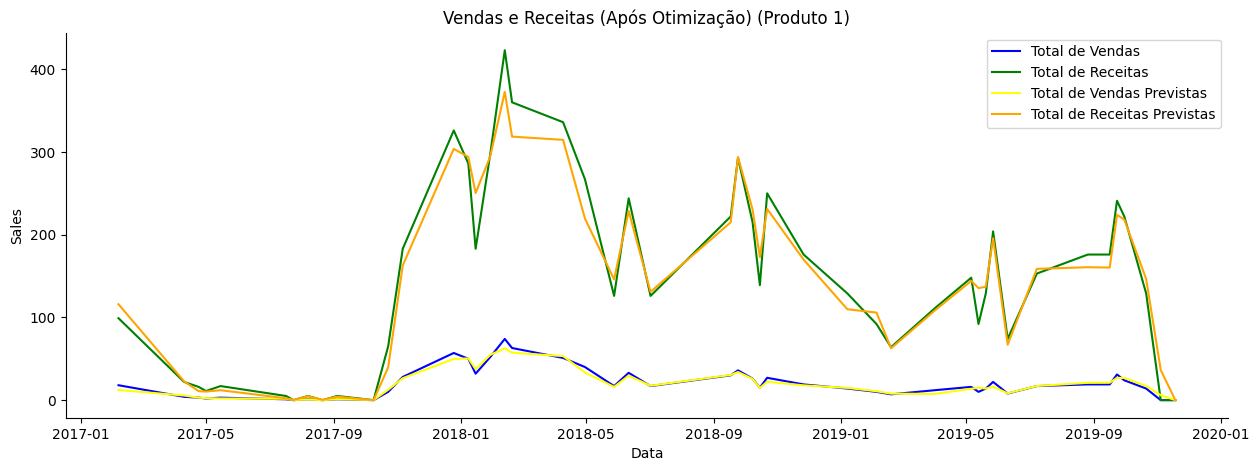

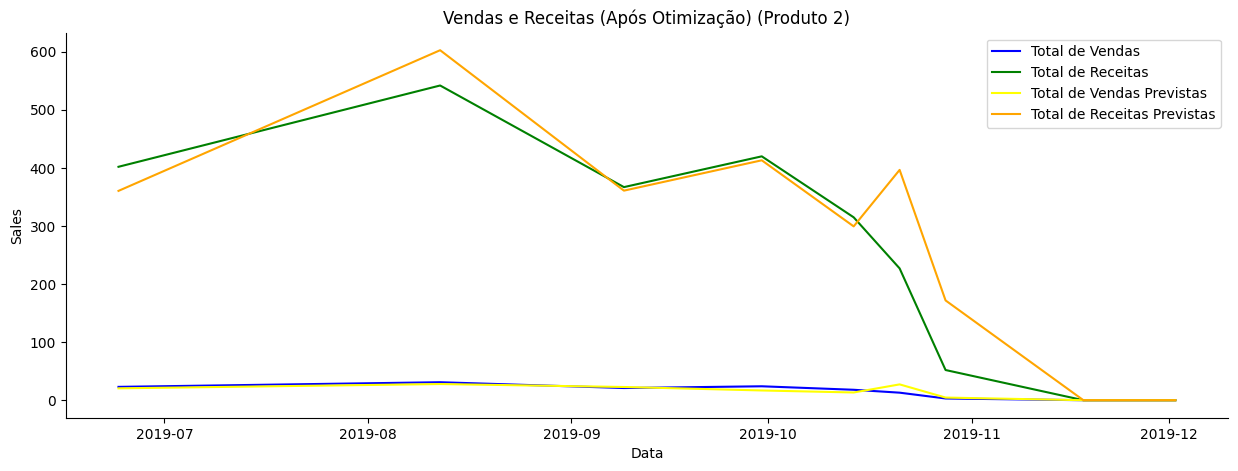

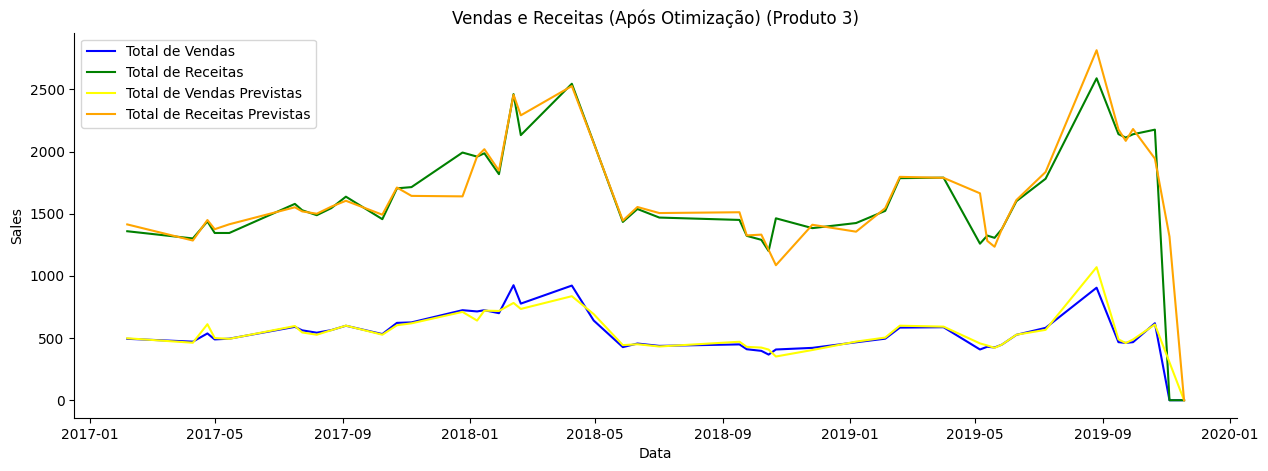

In [90]:


# Comparamos visualmente novamente os valores previstos com os valores reais, desta vez já após a aplicação de técnicas de otimização, permitindo
# aferir de uma forma mais percetível a diferença de desempenho obtida pelos modelos após a otimização
# É importante salientar que a linearidade não será, naturalmente, bem representada nestes gráficos, devido ao facto de o split de dados em conjuntos de teste e treino ter sido de forma aleatória,
# não contínua, isto é, são apenas apresentados os dados referentes à amostra de testes, para efeitos de comparação com as previsões. 
# A decisão de realizar o split desta forma, surge para evitar que o modelo se torne demasiado otimista para um determinado período contínuo, procurando mitigar a possibilidade de overfitting
time_plot(dataframe_with_forecast1.dropna(), 'sales', 'revenue', 'Vendas e Receitas (Após Otimização) (Produto 1)', False, True)
time_plot(dataframe_with_forecast2.dropna(), 'sales', 'revenue', 'Vendas e Receitas (Após Otimização) (Produto 2)', False, True)
time_plot(dataframe_with_forecast3.dropna(), 'sales', 'revenue', 'Vendas e Receitas (Após Otimização) (Produto 3)', False, True)



In [104]:
# Escolhemos o modelo que iremos utilizar, cujas configurações serão analisadas com base nos resultados obtidos para efeitos de otimização
model = XGBRegressor(objective='reg:squarederror')

# Criamos um dataframe onde serão armazenados os resultados dos modelos obtidos para posterior análise/comparação
modelResults = pd.DataFrame(columns=["product_id", "rmse_sales", "rmse_revenue", "r2_sales", "r2_revenue"])
modelResults_optimized = pd.DataFrame(columns=["product_id", "rmse_sales", "rmse_revenue", "r2_sales", "r2_revenue"])

# Iteramos a lista de dataframes, treinando um modelo para cada produto e armazenando os respetivos resultados
for name, group in dfByProdList:
    group_prep = prepareBeforePredict(group)
    group_prep_optimized = prepareBeforePredictOptimized(group)
    
    if(len(group_prep.sales.unique()) > 3) & (len(group_prep.revenue.unique()) > 3):
        rmse_sales, rmse_revenue, mae_sales, mae_revenue, r2_sales, r2_revenue, _ = predict(group_prep, model, salesColsToDrop, revenueColsToDrop)

        modelResults = pd.concat([modelResults,  pd.DataFrame.from_records([{"product_id": name, "rmse_sales": rmse_sales, "rmse_revenue": rmse_revenue, "mae_sales": mae_sales, 
            "mae_revenue": mae_revenue, "r2_sales": r2_sales, "r2_revenue": r2_revenue}])])

        rmse_sales, rmse_revenue, mae_sales, mae_revenue, r2_sales, r2_revenue, _ = predict(group_prep_optimized, model, salesColsToDrop_optimized, revenueColsToDrop_optimized)

        modelResults_optimized = pd.concat([modelResults_optimized,  pd.DataFrame.from_records([{"product_id": name, "rmse_sales": rmse_sales, "rmse_revenue": rmse_revenue, "mae_sales": mae_sales, 
            "mae_revenue": mae_revenue, "r2_sales": r2_sales, "r2_revenue": r2_revenue}])])
    


In [105]:

print(modelResults.head())
print(modelResults_optimized.head())

  product_id  rmse_sales  rmse_revenue  r2_sales  r2_revenue  mae_sales  \
0      P0001    8.966934     63.530500  0.755841    0.676885   6.593158   
0      P0002    1.903361    318.790390 -0.176471   -0.131023   0.832789   
0      P0004    3.232650     12.162788 -0.185802   -0.414425   2.224238   
0      P0005    3.348815    124.296515 -0.311433   -0.114372   2.642100   
0      P0006    1.612621     39.820895  0.348632    0.302333   0.734637   

   mae_revenue  
0    45.230977  
0   162.521318  
0     8.617840  
0    96.550692  
0    19.250768  
  product_id  rmse_sales  rmse_revenue  r2_sales  r2_revenue  mae_sales  \
0      P0001    3.424841     21.162310  0.964382    0.964148   2.330519   
0      P0002    1.281089    188.034727  0.467036    0.606507   0.318520   
0      P0004    2.095213      5.947805  0.501860    0.661758   1.032707   
0      P0005    1.043158     34.770963  0.872748    0.912794   0.701069   
0      P0006    1.446754     33.087146  0.475735    0.518335   0.508178 

In [106]:


# Verificamos a média do desempenho dos modelos para todos os produtos válidos (com dados suficientes para prever)
print(f"Média MAE de Receitas: {modelResults[modelResults['r2_sales'] > -1].rmse_sales.mean()}")
print(f"Média MAE de Vendas: {modelResults[modelResults['r2_revenue'] > -1].rmse_revenue.mean()}")
print(f"Média MAE de Receitas: {modelResults[modelResults['r2_sales'] > -1].mae_sales.mean()}")
print(f"Média MAE de Vendas: {modelResults[modelResults['r2_revenue'] > -1].mae_revenue.mean()}")
print(f"Média R2 Score  de Vendas: {modelResults[modelResults['r2_sales'] > -1].r2_sales.mean()}")
print(f"Média R2 Score de Receitas: {modelResults[modelResults['r2_revenue'] > -1].r2_revenue.mean()}")



Média MAE de Receitas: 74.55427523628461
Média MAE de Vendas: 902.4687373052685
Média MAE de Receitas: 35.42814233827156
Média MAE de Vendas: 393.16890070697684
Média R2 Score  de Vendas: 0.19948515687647145
Média R2 Score de Receitas: 0.2169577275252703


In [107]:


# Verificamos a média do desempenho dos modelos para todos os produtos válidos, após aplicação de técnicas de otimização
print(f"---Após Otimização---")
print(f"Média MAE de Receitas: {modelResults_optimized[modelResults_optimized['r2_sales'] > -1].rmse_sales.mean()}")
print(f"Média MAE de Vendas: {modelResults_optimized[modelResults_optimized['r2_revenue'] > -1].rmse_revenue.mean()}")
print(f"Média MAE de Receitas: {modelResults_optimized[modelResults_optimized['r2_sales'] > -1].mae_sales.mean()}")
print(f"Média MAE de Vendas: {modelResults_optimized[modelResults_optimized['r2_revenue'] > -1].mae_revenue.mean()}")
print(f"Média R2 Score  de Vendas: {modelResults_optimized[modelResults_optimized['r2_sales'] > -1].r2_sales.mean()}")
print(f"Média R2 Score de Receitas: {modelResults_optimized[modelResults_optimized['r2_revenue'] > -1].r2_revenue.mean()}")



---Após Otimização---
Média MAE de Receitas: 45.659408269052115
Média MAE de Vendas: 690.4418839092712
Média MAE de Receitas: 19.005105709254003
Média MAE de Vendas: 275.47409144107473
Média R2 Score  de Vendas: 0.7427532259996374
Média R2 Score de Receitas: 0.769176945587907


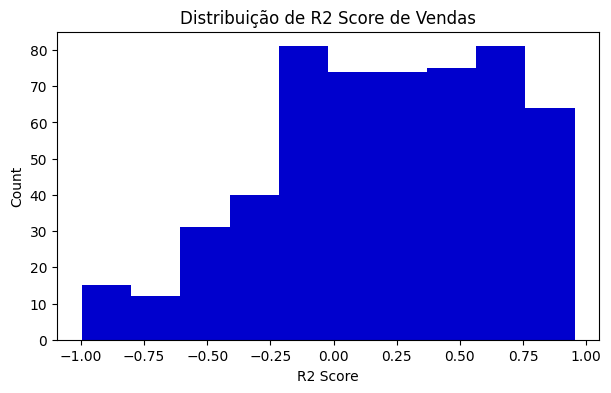

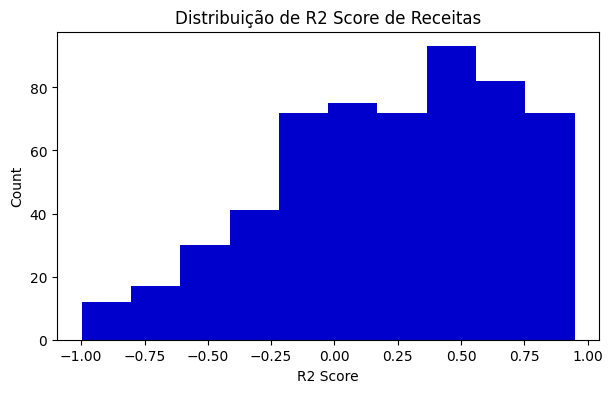

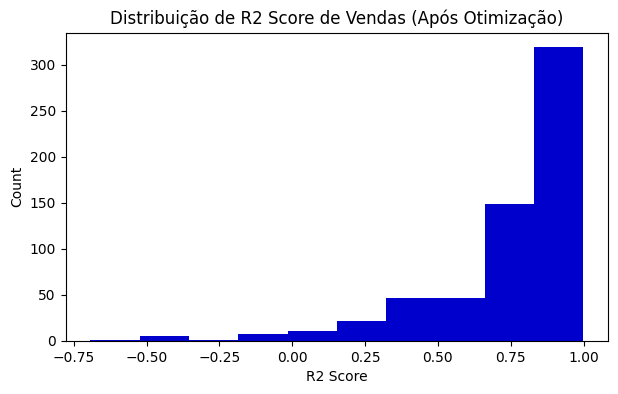

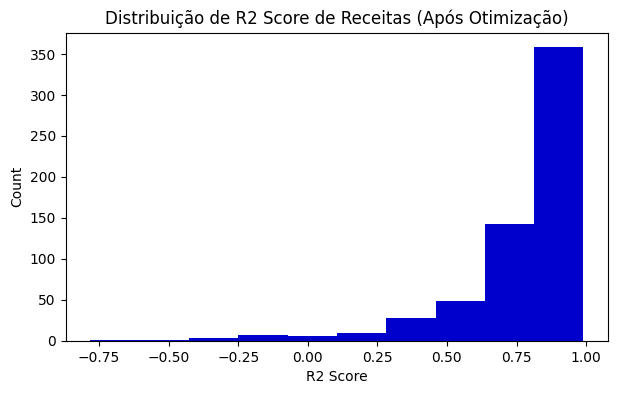

In [108]:

def r2_distribution_sales(modelResults, title):
    fig, ax = plt.subplots(figsize=(7,4))
    plt.hist(modelResults.r2_sales, color='mediumblue')
    
    ax.set(xlabel = "R2 Score", ylabel = "Count", title = title )

def r2_distribution_revenue(modelResults, title):
    fig, ax = plt.subplots(figsize=(7,4))
    plt.hist(modelResults.r2_revenue, color='mediumblue')
    
    ax.set(xlabel = "R2 Score", ylabel = "Count", title = title )


# Verificamos a distribuição do R2 Score de todos os modelos obtidos
r2_distribution_sales(modelResults[modelResults['r2_sales'] > -1], "Distribuição de R2 Score de Vendas")
r2_distribution_revenue(modelResults[modelResults['r2_revenue'] > -1], "Distribuição de R2 Score de Receitas")

# Verificamos a distribuição do R2 Score de todos os modelos obtidos, após aplicação de técnicas de otimização
r2_distribution_sales(modelResults_optimized[modelResults_optimized['r2_sales'] > -1], "Distribuição de R2 Score de Vendas (Após Otimização)")
r2_distribution_revenue(modelResults_optimized[modelResults_optimized['r2_revenue'] > -1], "Distribuição de R2 Score de Receitas (Após Otimização)")

